# Part 1-1. Data Analysis

In [8]:
# Importing necessary libraries
import numpy as np
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import statsmodels.api as sm
from scipy.stats import f,t
import scipy.stats as stats
# import pymc as pm

In [9]:
### Loading datasets ###

with open("data_training.pkl", 'rb') as file: # Loading training data set
    data_training = pickle.load(file)
    
with open("data_prediction.pkl", 'rb') as file: # Loading prediction data set
    data_prediction = pickle.load(file)

with open("lat.pkl", 'rb') as file: # Loading latitude
    lat = pickle.load(file)

with open("lon.pkl", 'rb') as file: # Loading longitude
    lon = pickle.load(file)

# Display some features of the file contents
print('Training dataset: ',type(data_training))
print(data_training.shape)
print('\nPrediction dataset: ', type(data_prediction))
print(data_prediction.shape)
print('\nLatitudes: ', type(lat))
print(lat.shape)
print('\nLongitude: ', type(lon))
print(lon.shape)


# Extract the slices [118, 83, :, :] indicating information for the 90 days in South Bend (with shape (90, 10))
SB_data_X = data_training[118, 83, :, :9]
SB_data_Y = data_training[118, 83, :, 9]

# Naming columns and create a pandas DataFrame
column_names_data_X = ['ALBEDO', 'CLDHGH', 'CLDMID', 'CLDLOW', 'QLML', 'SWGDN', 'SPEED', 'PRECSNO', 'PRECTOT']
column_names_data_Y = ['TLML']
df_X_data = pd.DataFrame(SB_data_X, columns=column_names_data_X)
df_Y = pd.DataFrame(SB_data_Y, columns=column_names_data_Y)

# Defining a new feature (average temperature of eight surrounding locations around South Bend)
num_of_days = len(data_training[118,83,:,9])
avg_8temp = np.zeros(num_of_days) # Average temperature of eight surrounding locations
for i in range(num_of_days):
    avg_8temp[i] = (data_training[117, 82, i, 9] + 
                    data_training[117, 83, i, 9] + 
                    data_training[117, 84, i, 9] + 
                    data_training[118, 82, i, 9] + 
                    data_training[118, 84, i, 9] + 
                    data_training[119, 82, i, 9] + 
                    data_training[119, 83, i, 9] + 
                    data_training[119, 84, i, 9])/8
# plt.figure()
# plt.scatter(avg_8temp, df_Y.values)
# plt.show()


# Add the new feature to the dataframe
df_X_data['avg8temp'] = avg_8temp


# Turn the data to numpy array
X = df_X_data.to_numpy()
Y = df_Y.to_numpy()

# Display the DataFrame
print('\ndf_X_data: ')
print(df_X_data)
print('\ndf_Y: ')
print(df_Y)


# Create a dataframe for visualizations
merged_df = pd.concat([df_Y, df_X_data], axis=1) # Merge the dataframes (Y and covariates) into one dataframe
merged_df['Days'] = range(1,len(merged_df)+1) # Add a 'Days' column to the dataframe
columns = ['Days'] + [col for col in merged_df.columns if col != 'Days']  # Adjust column order ('Days' before 'Y')
merged_df = merged_df[columns] # Adjust column order ('Days' before 'Y')
print('\nmerged_df: ')
print(merged_df)

Training dataset:  <class 'numpy.ndarray'>
(182, 101, 90, 10)

Prediction dataset:  <class 'numpy.ndarray'>
(182, 101, 90, 10)

Latitudes:  <class 'pandas.core.frame.DataFrame'>
(101, 1)

Longitude:  <class 'pandas.core.frame.DataFrame'>
(182, 1)

df_X_data: 
      ALBEDO    CLDHGH    CLDMID    CLDLOW      QLML       SWGDN      SPEED  \
0   0.192835  0.000000  0.106757  0.433253  0.003614   63.816284   9.833626   
1   0.185830  0.055842  0.092260  0.512400  0.003632   64.362549   7.763040   
2   0.186345  0.197483  0.000000  0.309935  0.002707   95.904297   4.559177   
3   0.174823  0.578273  0.586356  0.173380  0.003001   43.314514   3.938585   
4   0.249486  0.047220  0.112427  0.495041  0.003464   73.194906   5.467694   
..       ...       ...       ...       ...       ...         ...        ...   
85  0.162944  0.565833  0.212711  0.499898  0.008997   81.016393   9.889203   
86  0.178715  0.031142  0.034219  0.547162  0.003090  100.275289  10.792226   
87  0.174408  0.224985  0.462

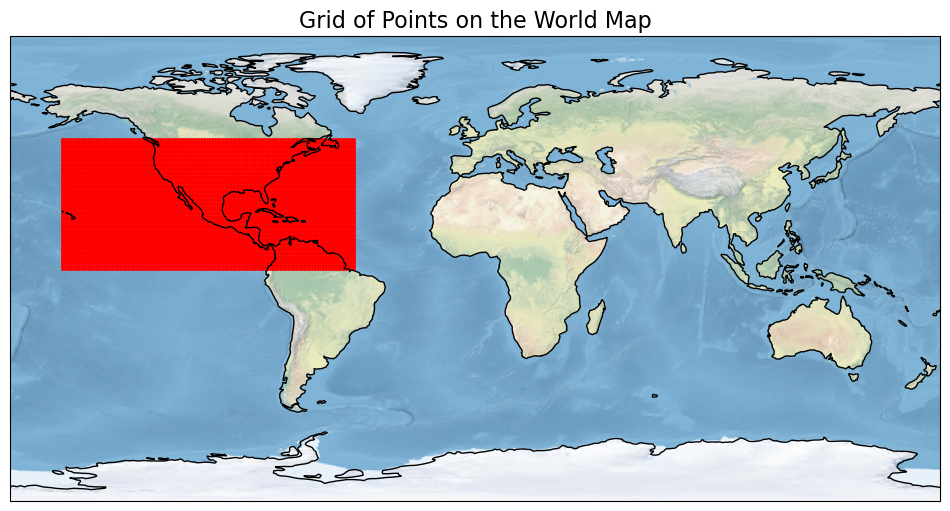

[-160.] [-46.875] [-1.7975103e-13] [50.]


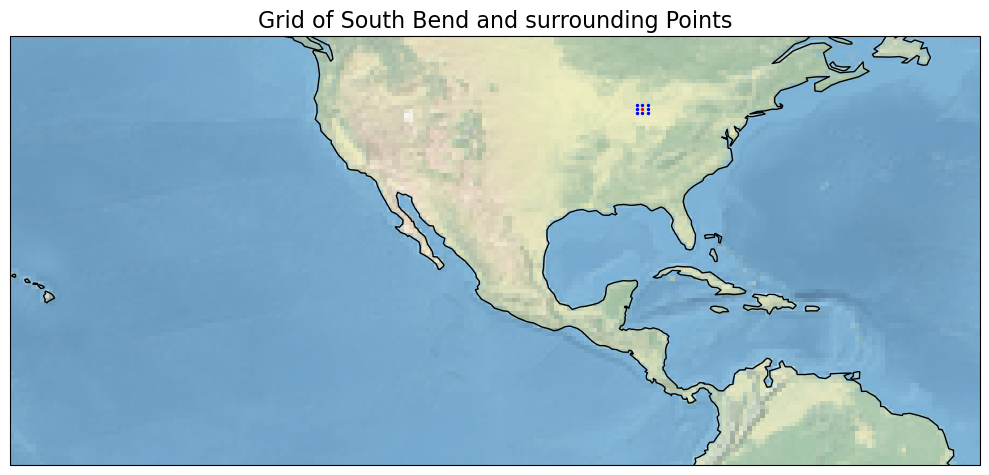

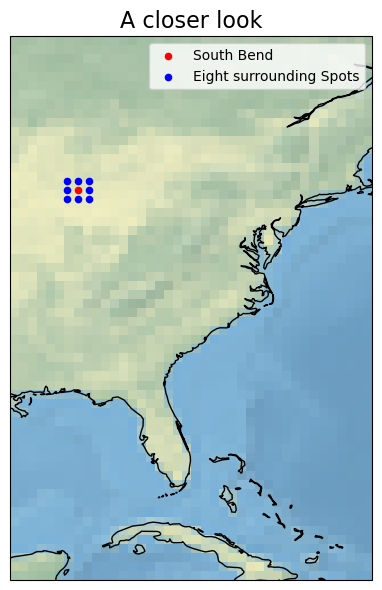

In [3]:
### Plotting longitudes and latitudes (grids) over a real map ###

# Create a meshgrid
lon_grid, lat_grid = np.meshgrid(lon.values, lat.values)

# Create a map projection
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Add map background
ax.stock_img()
ax.coastlines()

# Plot the points
ax.scatter(lon_grid, lat_grid, s=1, color='red', transform=ccrs.PlateCarree())

# Set map title
ax.set_title("Grid of Points on the World Map", fontsize=16)
plt.show()

# Set the extent to the red area (longitude and latitude bounds)
print(min(lon.values), max(lon.values), min(lat.values), max(lat.values))
# print(lat.values)



# SB and the eight surrounding locations
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

ax.set_extent([min(lon.values), max(lon.values), min(lat.values), max(lat.values)], crs=ccrs.PlateCarree())

# Add map background
ax.stock_img()
ax.coastlines()

# Plot the points within the red area
ax.scatter(lon.values[118], lat.values[83], s=2, color='red', transform=ccrs.PlateCarree()) # South Bend (SB)
ax.scatter(lon.values[117], lat.values[83], s=2, color='blue', transform=ccrs.PlateCarree()) # West of SB
ax.scatter(lon.values[119], lat.values[83], s=2, color='blue', transform=ccrs.PlateCarree()) # East of SB
ax.scatter(lon.values[118], lat.values[84], s=2, color='blue', transform=ccrs.PlateCarree()) # North of SB
ax.scatter(lon.values[118], lat.values[82], s=2, color='blue', transform=ccrs.PlateCarree()) # South of SB
ax.scatter(lon.values[117], lat.values[84], s=2, color='blue', transform=ccrs.PlateCarree()) # NorthWest of SB
ax.scatter(lon.values[119], lat.values[84], s=2, color='blue', transform=ccrs.PlateCarree()) # NorthEast of SB
ax.scatter(lon.values[117], lat.values[82], s=2, color='blue', transform=ccrs.PlateCarree()) # SouthWest of SB
ax.scatter(lon.values[119], lat.values[82], s=2, color='blue', transform=ccrs.PlateCarree()) # SouthEast of SB

# Set map title
ax.set_title("Grid of South Bend and surrounding Points", fontsize=16)
plt.tight_layout()
plt.savefig('SBand8Spots.png', dpi=300)
plt.show()



# A closer look at SB and the eight surrounding locations
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

ax.set_extent([-90.0, -70.0, 20.0, 50.0], crs=ccrs.PlateCarree())

# Add map background
ax.stock_img()
ax.coastlines()

# Plot the points within the red area
ax.scatter(lon.values[118], lat.values[83], s=20, color='red', transform=ccrs.PlateCarree(), label='South Bend') # South Bend (SB)
ax.scatter(lon.values[117], lat.values[83], s=20, color='blue', transform=ccrs.PlateCarree(), label = 'Eight surrounding Spots') # West of SB
ax.scatter(lon.values[119], lat.values[83], s=20, color='blue', transform=ccrs.PlateCarree()) # East of SB
ax.scatter(lon.values[118], lat.values[84], s=20, color='blue', transform=ccrs.PlateCarree()) # North of SB
ax.scatter(lon.values[118], lat.values[82], s=20, color='blue', transform=ccrs.PlateCarree()) # South of SB
ax.scatter(lon.values[117], lat.values[84], s=20, color='blue', transform=ccrs.PlateCarree()) # NorthWest of SB
ax.scatter(lon.values[119], lat.values[84], s=20, color='blue', transform=ccrs.PlateCarree()) # NorthEast of SB
ax.scatter(lon.values[117], lat.values[82], s=20, color='blue', transform=ccrs.PlateCarree()) # SouthWest of SB
ax.scatter(lon.values[119], lat.values[82], s=20, color='blue', transform=ccrs.PlateCarree()) # SouthEast of SB

# Set map title
plt.legend()
ax.set_title("A closer look", fontsize=16)
plt.tight_layout()
plt.savefig('CloserLook.png', dpi=300)
plt.show()

In [4]:
# Computing the condition number before scaling
cond_num_bef = np.linalg.cond(X)

# Scale the matrix
X_scaled = StandardScaler().fit_transform(X)

# Computing the condition number after scaling
cond_num_aft = np.linalg.cond(X_scaled)

# Print the results
print('Condition number before scaling: ', cond_num_bef)
print('Condition number after scaling: ', cond_num_aft)

Condition number before scaling:  5083731.497989
Condition number after scaling:  8.210273565743


In [5]:
# Scaling each covariate by its std
X_RescaledPart2 = X * 0 # Initialize an array of zeros with the same shape as X (90,10)
# print(X_RescaledPart2.shape)
for i in range(len(X[0,:])):
    X_RescaledPart2[:,i] = X[:,i]/np.std(X[:,i])
    

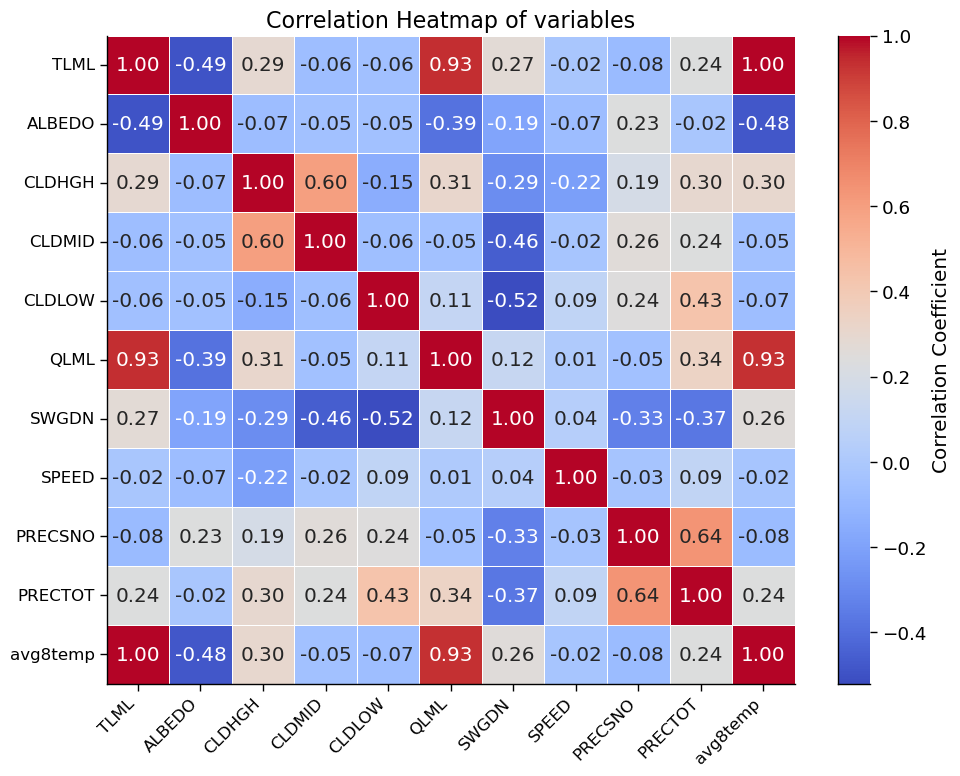

In [6]:
# Plotting the heatmap of correlations

# Calculate the correlation matrix from the dataframe from which "Days" column is excluded
correlation_matrix = merged_df.drop(columns=['Days']).corr()

# Set up the heatmap
sns.set_context("paper", font_scale=1.5)  # Adjust font size for publication
plt.figure(figsize=(10, 8))  # Adjust figure size
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True,
            linewidths=0.5, cbar_kws={"label": "Correlation Coefficient"})

# Add labels and title
plt.title("Correlation Heatmap of variables", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
sns.despine()
plt.tight_layout()

# Save the heatmap
plt.savefig("variables_correlation_heatmap.png", dpi=300)

# Show the heatmap
plt.show()

         TLML      QLML    ALBEDO       SWGDN   avg8temp
0   35.096399  0.003614  0.192835   63.816284  35.635489
1   35.291047  0.003632  0.185830   64.362549  35.924033
2   34.430556  0.002707  0.186345   95.904297  33.922498
3   30.859787  0.003001  0.174823   43.314514  31.561245
4   31.756038  0.003464  0.249486   73.194906  32.549136
..        ...       ...       ...         ...        ...
85  55.430089  0.008997  0.162944   81.016393  54.077233
86  30.332795  0.003090  0.178715  100.275289  30.201010
87  28.900716  0.002060  0.174408  162.870585  29.211279
88  38.012740  0.003490  0.178408  168.785685  38.495076
89  47.126455  0.006679  0.156077   77.762299  47.027066

[90 rows x 5 columns]
Index(['TLML [°F]', 'QLML', 'ALBEDO', 'SWGDN [W/m²]', 'avg8temp [°F]'], dtype='object')


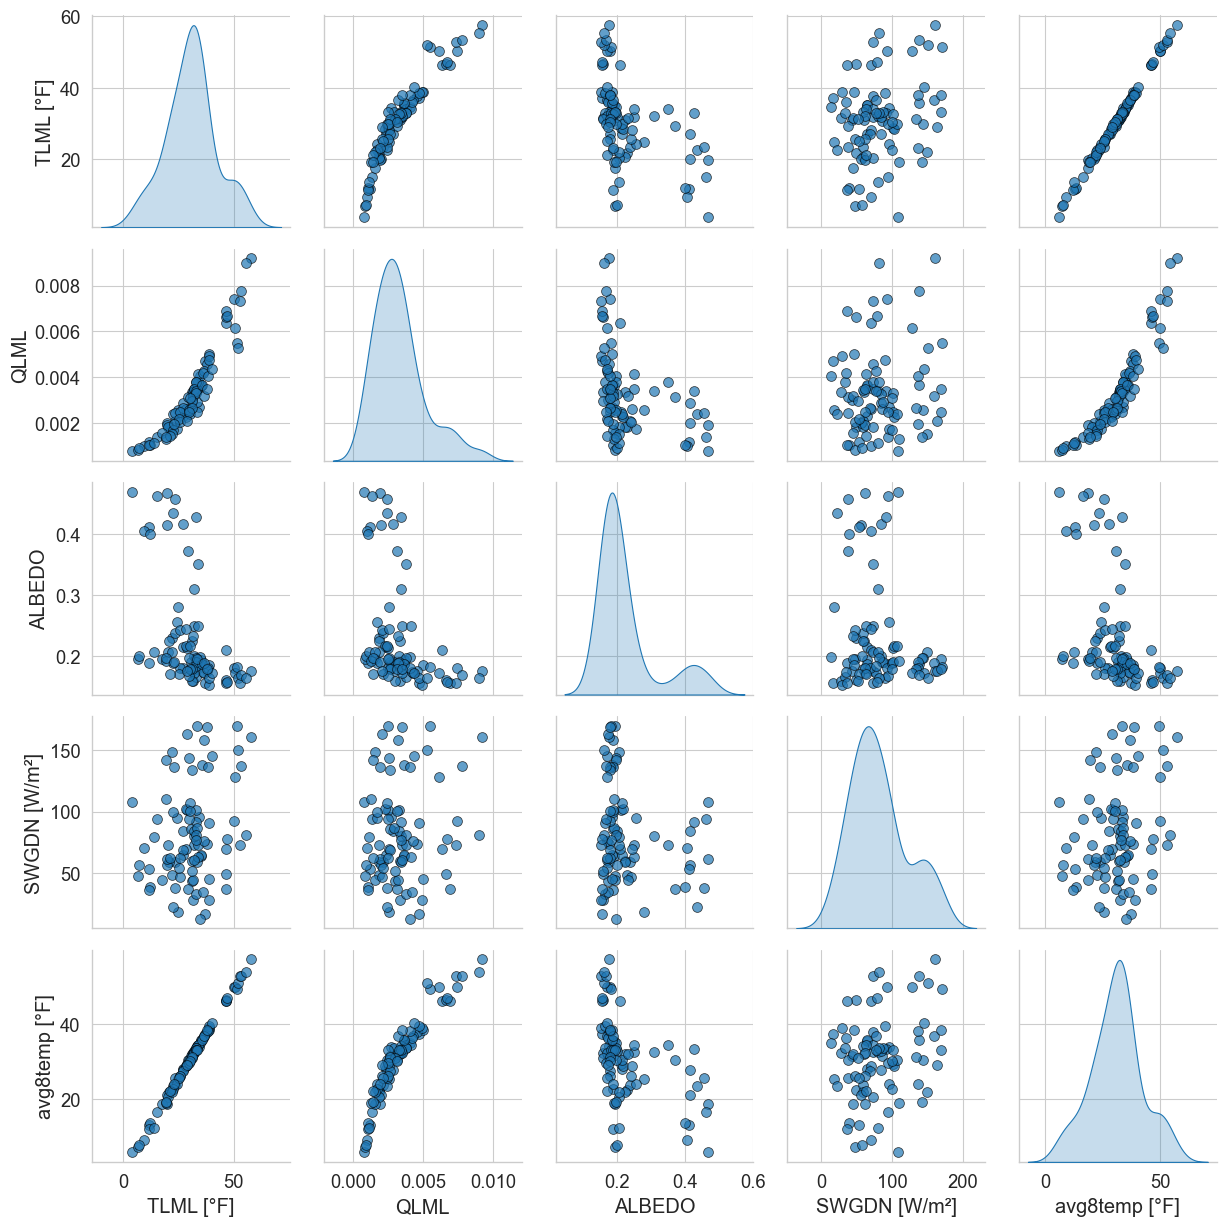

In [7]:
# Plot the pairplot of Y and its four most correlated covariates
new_merged_df = merged_df[['TLML', 'QLML', 'ALBEDO', 'SWGDN', 'avg8temp']]
print(new_merged_df)

# Redefine a dataframe to include the units as well
new_merged_df_unitsIncluded = new_merged_df
new_merged_df_unitsIncluded.columns = ['TLML [°F]', 'QLML', 'ALBEDO', 'SWGDN [W/m²]', 'avg8temp [°F]']
print(new_merged_df_unitsIncluded.columns)

# Set publication-quality style
sns.set_context("paper", font_scale=1.5)  # Adjust font size for publication
sns.set_style("whitegrid")  # Clean grid background

# Create the pairplot
pairplot = sns.pairplot(new_merged_df, 
                        diag_kind="kde",  # Use kernel density estimation for diagonal plots
                        plot_kws={"s": 50, "edgecolor": "black", "alpha": 0.7})  # Adjust diagonal plots

# # remove upper triangle plots
# for i, j in zip(*np.triu_indices_from(pairplot.axes, 1)):
#     pairplot.axes[i, j].set_visible(False)

# Add a tight layout for cleaner formatting
pairplot.fig.tight_layout()

# Save the plot
pairplot.savefig("pairplot_publication_quality.png", dpi=300)  # Save as PNG with high DPI

# Show the plot
plt.show()

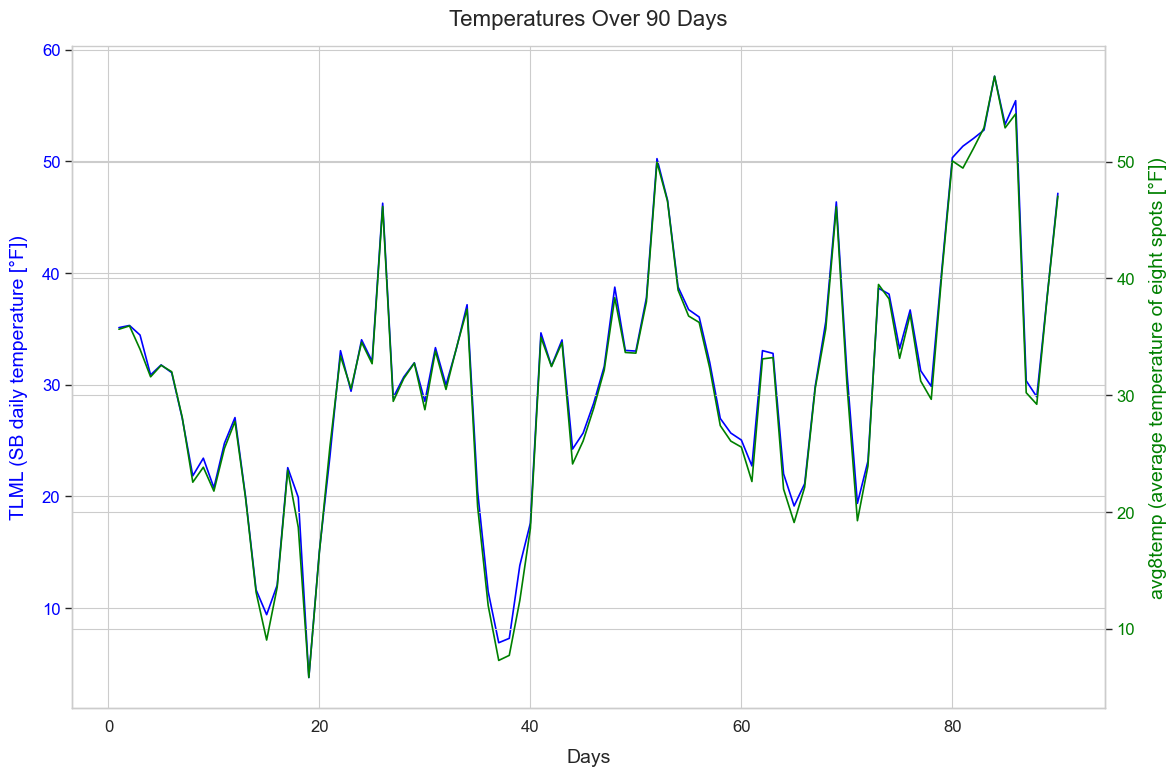

In [8]:
# Plotting the South Bend and the average of its surroundings temperature trends over 90 days

# Set style and context
sns.set_context("paper", font_scale=1.5)  # Adjust for a smaller, journal-like scale
sns.set_style("whitegrid")  # Clean background with grid lines

# Create figure and primary axis for temperature
fig, ax1 = plt.subplots(figsize=(12, 8))  # Set figure size to typical journal dimensions

# Plot Daily Temperature as a line plot on the primary axis
sns.lineplot(
    x="Days", y="TLML", data=merged_df, color="blue", ax=ax1)
ax1.set_xlabel("Days", fontsize=14, labelpad=10)
ax1.set_ylabel("TLML (SB daily temperature [°F])", fontsize=14, labelpad=10, color="blue")
ax1.tick_params(axis="y", labelcolor="blue", labelsize=12)
ax1.tick_params(axis="x", labelsize=12)

# Create a secondary axis for South-to-North wind speed
ax2 = ax1.twinx()
sns.lineplot(
    x="Days", y="avg8temp", data=merged_df, color="green", ax=ax2)
ax2.set_ylabel("avg8temp (average temperature of eight spots [°F])", fontsize=14, labelpad=10, color="green")
ax2.tick_params(axis="y", labelcolor="green", labelsize=12)

# Add title
plt.title("Temperatures Over 90 Days", fontsize=16, pad=15)

# Clean up and finalize
sns.despine(ax=ax1, right=False)  # Remove unnecessary spines
fig.tight_layout()  # Ensure proper layout for publication
plt.savefig("Temperatures_trend.png", dpi=300)  # Save as PNG with high DPI
plt.show()

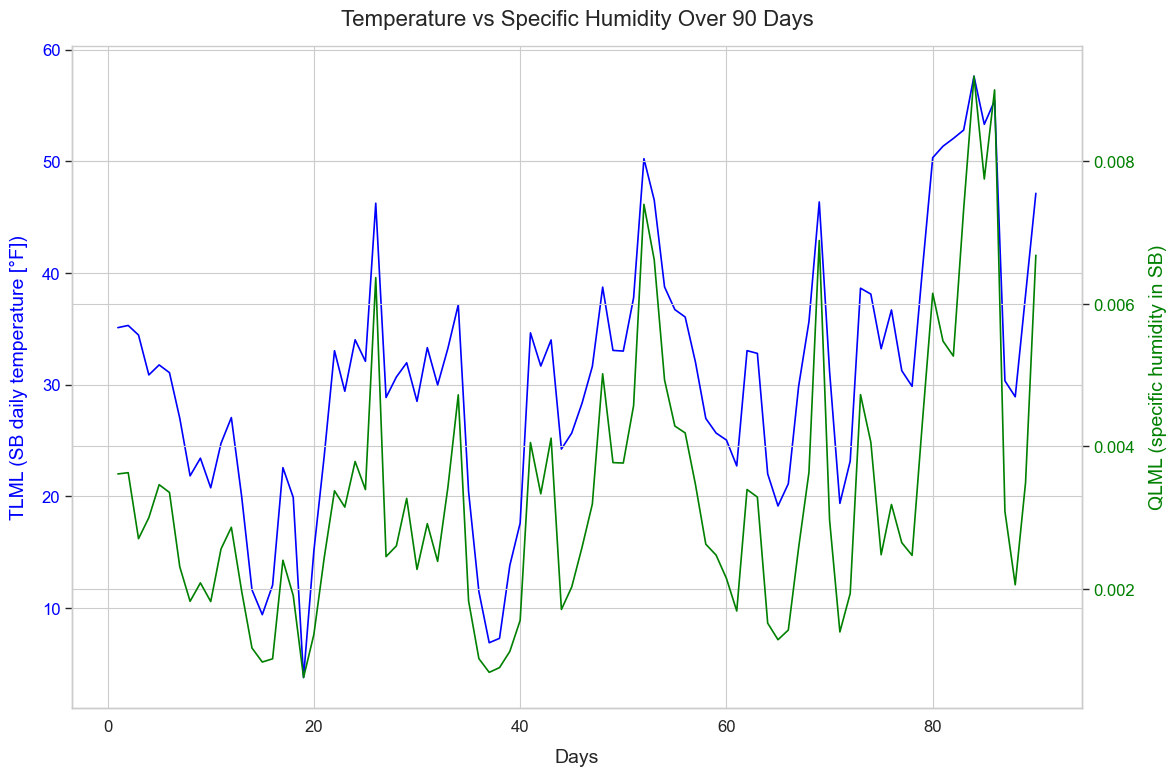

In [9]:
# Plotting the South Bend temperature and specific humidity over 92 days

# Set style and context
sns.set_context("paper", font_scale=1.5)  # Adjust for a smaller, journal-like scale
sns.set_style("whitegrid")  # Clean background with grid lines

# Create figure and primary axis for temperature
fig, ax1 = plt.subplots(figsize=(12, 8))  # Set figure size to typical journal dimensions

# Plot Daily Temperature as a line plot on the primary axis
sns.lineplot(
    x="Days", y="TLML", data=merged_df, color="blue", ax=ax1)
ax1.set_xlabel("Days", fontsize=14, labelpad=10)
ax1.set_ylabel("TLML (SB daily temperature [°F])", fontsize=14, labelpad=10, color="blue")
ax1.tick_params(axis="y", labelcolor="blue", labelsize=12)
ax1.tick_params(axis="x", labelsize=12)

# Create a secondary axis for South-to-North wind speed
ax2 = ax1.twinx()
sns.lineplot(
    x="Days", y="QLML", data=merged_df, color="green", ax=ax2)
ax2.set_ylabel("QLML (specific humidity in SB)", fontsize=14, labelpad=10, color="green")
ax2.tick_params(axis="y", labelcolor="green", labelsize=12)

# Add title
plt.title("Temperature vs Specific Humidity Over 90 Days", fontsize=16, pad=15)

# Clean up and finalize
sns.despine(ax=ax1, right=False)  # Remove unnecessary spines
fig.tight_layout()  # Ensure proper layout for publication
plt.savefig("Temperatures_SpcHumidity_trend.png", dpi=300)  # Save as PNG with high DPI
plt.show()

## ALL Three Models

In [10]:
### Defining the three model inputs ###
# print(type(X_RescaledPart2))
# print(X_RescaledPart2.shape)

X_MODEL_1 = X_RescaledPart2[:,9] # Only avg8temp
print(X_MODEL_1.shape)
X_MODEL_2 = X_RescaledPart2[:,[0,4,5]] # ALBEDO, QLML, SWGDN (in order)
print(X_MODEL_2.shape)
X_MODEL_3 = X_RescaledPart2[:,:9] # ALBEDO, CLDHGH, CLDMID, CLDLOW, QLML, SWGDN, SPEED, PRECSNO, PRECTOT (in order)
print(X_MODEL_3.shape)


(90,)
(90, 3)
(90, 9)


In [11]:
### Performing regression with the scaled covariates for later comparison and verification purposes ###

# Linear regression using statsmodels for X_MODEL_1
model_1 = sm.OLS(Y, sm.add_constant(X_MODEL_1)).fit()
print('MODEL-1: ')
print(model_1.summary())
print(np.shape(model_1.params))

# Linear regression using statsmodels for X_MODEL_2
model_2 = sm.OLS(Y, sm.add_constant(X_MODEL_2)).fit()
print('\nMODEL-2: ')
print(model_2.summary())
print(np.shape(model_2.params))

# Linear regression using statsmodels for X_MODEL_3
model_3 = sm.OLS(Y, sm.add_constant(X_MODEL_3)).fit()
print('\nMODEL-3: ')
print(model_3.summary())
print(np.shape(model_3.params))

MODEL-1: 
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 3.146e+04
Date:                Mon, 16 Dec 2024   Prob (F-statistic):          3.40e-114
Time:                        10:39:58   Log-Likelihood:                -80.459
No. Observations:                  90   AIC:                             164.9
Df Residuals:                      88   BIC:                             169.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1291      0.190     -5.94

In [12]:
### Doing linear regression with matrix notation ###

# Defining a function to compute estimates
def estimates_calculator(Y, X):
    n = len(Y)
    X0 = np.ones(n)
    X_matrix = np.column_stack((X0, X))
    Y_matrix = Y

    # Doing basic operations and find the estimates
    XX = X_matrix.T @ X_matrix
    XY = X_matrix.T @ Y_matrix
    XXI = np.linalg.inv(XX)
    b = XXI @ XY

    return b


# Compute the estimates for MODEL-1
b_model_1 = estimates_calculator(Y,X_MODEL_1)

# Iterate through both arrays and print the values
print('\n         MODEL-1 ')
print('   Manual   ', 'lm package')
print(' ---------- ', '----------')
for i in range(len(b_model_1)):
    print(f"{b_model_1[i, 0]:10.4f}  {model_1.params[i]:10.4f}")



# Compute the estimates for MODEL-2
b_model_2 = estimates_calculator(Y,X_MODEL_2)

# Iterate through both arrays and print the values
print('\n         MODEL-2 ')
print('   Manual   ', 'lm package')
print(' ---------- ', '----------')
for i in range(len(b_model_2)):
    print(f"{b_model_2[i, 0]:10.4f}  {model_2.params[i]:10.4f}")



# Compute the estimates for MODEL-3
b_model_3 = estimates_calculator(Y,X_MODEL_3)

# Iterate through both arrays and print the values
print('\n         MODEL-3 ')
print('   Manual   ', 'lm package')
print(' ---------- ', '----------')
for i in range(len(b_model_3)):
    print(f"{b_model_3[i, 0]:10.4f}  {model_3.params[i]:10.4f}")



         MODEL-1 
   Manual    lm package
 ----------  ----------
   -1.1291     -1.1291
   11.1854     11.1854

         MODEL-2 
   Manual    lm package
 ----------  ----------
   13.4639     13.4639
   -1.4357     -1.4357
    9.7240      9.7240
    1.6104      1.6104

         MODEL-3 
   Manual    lm package
 ----------  ----------
   18.3884     18.3884
   -1.7800     -1.7800
    0.1686      0.1686
   -0.2297     -0.2297
   -1.3203     -1.3203
    9.8442      9.8442
    0.9856      0.9856
   -0.3249     -0.3249
    0.7640      0.7640
   -0.1796     -0.1796


In [13]:
### Compute predictions and residuals using MODEL-1 ###

# Define a function to compute predictions and compare with the true values
def pred_computer(Y,X):
    n = len(Y)
    X0 = np.ones(n)
    X_matrix = np.column_stack((X0, X))
    Y_matrix = Y

    
    if X.ndim == 1:
        p = 1
    else:
        p = len(X[0,:])
    
    # Computing Y_hat
    XX = X_matrix.T @ X_matrix
    XXI = np.linalg.inv(XX)
    H = X_matrix @ XXI @ X_matrix.T
    Y_hat = (H @ Y_matrix).reshape(len(Y_matrix,))
    
    
    # Computing basic residuals
    r = (Y_matrix.reshape(len(Y_matrix,)) - Y_hat).reshape(len(Y_matrix,))
    
    # Computing MSE
    SSE = r.T @ r
    MSE = SSE / (n-p-1)
    
    return Y_hat, r, SSE, MSE, XXI

# Computing predictions for MODEL-1
Y_hat, r, SSE, MSE, XXI = pred_computer(Y,X_MODEL_1)
Y_hat2, r2, SSE2, MSE2, XXI2 = pred_computer(Y,X_MODEL_2)
Y_hat3, r3, SSE3, MSE3, XXI3 = pred_computer(Y,X_MODEL_3)
print(f"MSE of MODEL-1: {MSE:10.4f}")
print(f"MSE of MODEL-2: {MSE2:10.4f}")
print(f"MSE of MODEL-3: {MSE3:10.4f}")


# Standardized residuals
Days_np_arr = merged_df['Days'].to_numpy()
# print(Days_np_arr)
var_Days = np.var(Days_np_arr, ddof=1)
# print(var_Days)
n = len(Y)
SS_xx_Days = (n-1) * var_Days # sum( (xi - xbar)^2 )
print(SS_xx_Days)
print(MSE)
rr = r / np.sqrt(MSE * (1 - (1/n) - ((Days_np_arr-np.mean(Days_np_arr))**2/SS_xx_Days)))

MSE of MODEL-1:     0.3579
MSE of MODEL-2:    11.3611
MSE of MODEL-3:    10.3172
60742.5
0.35792604679689416


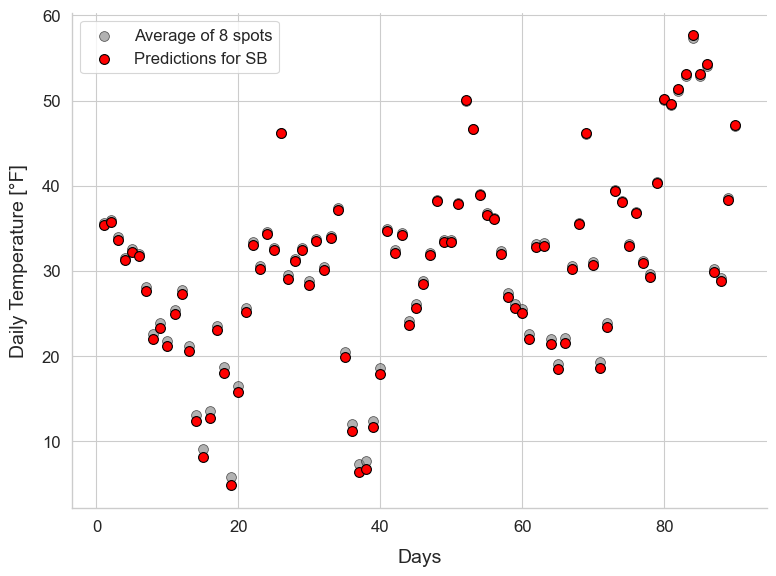

In [14]:
# Y_hat_test = b_model_1[0][0] + b_model_1[1][0] * X_MODEL_1
# print(Y_hat_test, Y_hat)

# Plotting to see the average temperature of surrounding areas and the predicted temperature for SB over days
sns.set_context("paper", font_scale=1.5)  # Adjust for a smaller, journal-like scale
sns.set_style("whitegrid")  # Clean background with grid lines
plt.figure(figsize=(8, 6))  # Set figure size to typical journal dimensions
sns.scatterplot(x="Days", y="avg8temp", data=merged_df, s=50, color="gray", label='Average of 8 spots', marker="o", edgecolor='black', alpha=0.6)
plt.scatter(merged_df['Days'], Y_hat, color='red', label='Predictions for SB', s=50, edgecolor='black')
# plt.scatter(merged_df['Days'], Y_hat_test, color='blue', label='Predictions for SB', s=50, edgecolor='black')
plt.xlabel("Days", fontsize=14, labelpad=10) # Set X-axis labels
plt.ylabel("Daily Temperature [°F]", fontsize=14, labelpad=10) # Set Y-axis labels
plt.xticks(fontsize=12) # Add ticks and their sizes
plt.yticks(fontsize=12) # Add ticks and their sizes
sns.despine() # Remove top and right spines for a cleaner look
plt.legend(loc="upper left", fontsize=12) # Add a legend
plt.tight_layout() # Set tight layout for better space usage
plt.savefig('Pred4trainDatasetVSavg8temp.png', dpi=300) # Save the plot as png
plt.show()


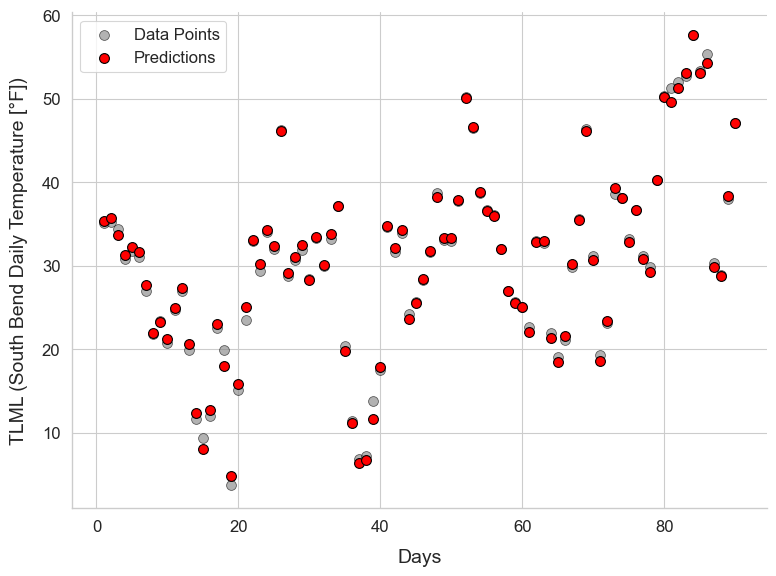

In [15]:
# Plotting the true and predictions over the course of days
sns.set_context("paper", font_scale=1.5)  # Adjust for a smaller, journal-like scale
sns.set_style("whitegrid")  # Clean background with grid lines
plt.figure(figsize=(8, 6))  # Set figure size to typical journal dimensions
sns.scatterplot(x="Days", y="TLML", data=merged_df, s=50, color="gray", label='Data Points', marker="o", edgecolor='black', alpha=0.6)
plt.scatter(merged_df['Days'], Y_hat, color='red', label='Predictions', s=50, edgecolor='black')
plt.xlabel("Days", fontsize=14, labelpad=10) # Set X-axis labels
plt.ylabel("TLML (South Bend Daily Temperature [°F])", fontsize=14, labelpad=10) # Set Y-axis labels
plt.xticks(fontsize=12) # Add ticks and their sizes
plt.yticks(fontsize=12) # Add ticks and their sizes
sns.despine() # Remove top and right spines for a cleaner look
plt.legend(loc="upper left", fontsize=12) # Add a legend
plt.tight_layout() # Set tight layout for better space usage
plt.savefig('YandYHatvsDays.png', dpi=300) # Save the plot as png
plt.show()

## MODEL-1

In [16]:
# Compute R^2 and R2_adj for MODEL-1
J_n = np.ones((n, n))
I_n = np.eye(n)
Y_matrix = Y
SST = Y_matrix.T @ (I_n - 1/n*J_n) @ Y_matrix
SSE = r.T @ r
SSR = (Y_hat.T @ Y_hat - 1/n* Y_matrix.T @ J_n @ Y_matrix)[0,0]
R2 = (1 - SSE/SST)[0][0]
if X_MODEL_1.ndim == 1:
    p = 1
else:
    p = len(X_MODEL_1[0,:])
R2_adj = 1 - ((1 - R2) * (n - 1) / (n - p - 1))
print(f"R^2: {R2:.4f}, Adjusted R^2: {R2_adj:.4f}")

# Compute MSE and std
MSE = SSE / (n-p-1)
s = np.sqrt(MSE)
print("MSE:", MSE)
print("Standard Deviation (sqrt(MSE)):", s)

# Global F-test
MSR = SSR / p
F_stat = MSR / MSE
p_value = 1 - f.cdf(F_stat, p, n - p - 1)
print(f"F-statistic: {F_stat:.4f}, p-value: {p_value:.4e}")

R^2: 0.9972, Adjusted R^2: 0.9972
MSE: 0.35792604679689416
Standard Deviation (sqrt(MSE)): 0.5982692093003735
F-statistic: 31459.5662, p-value: 1.1102e-16


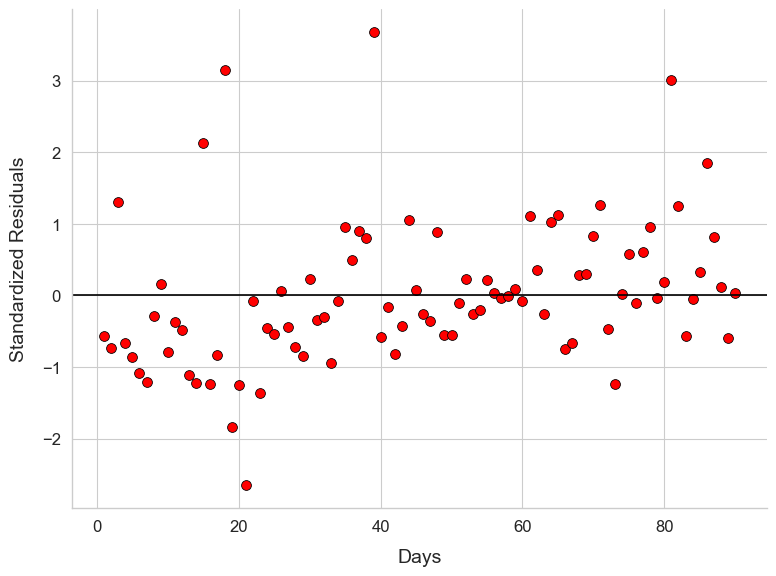

(90,)


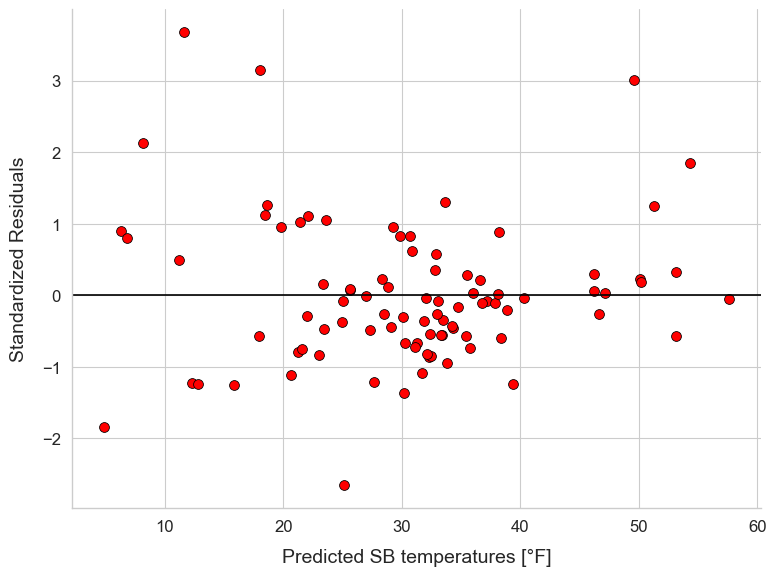

In [17]:
# Plotting standardized residuals vs Days (X)
sns.set_context("paper", font_scale=1.5)  # Adjust for a journal-like font scale
sns.set_style("whitegrid")  # Clean background with grid lines
plt.figure(figsize=(8, 6))  # Set figure size for a typical journal format
sns.scatterplot(x=Days_np_arr, y=rr, s=50, color="red", marker="o", edgecolor='black') # Advanced scatter plot using Seaborn
plt.axhline(0, color='black') # Add horizontal line at y=0
plt.xlabel("Days", fontsize=14, labelpad=10) # Set X-axis labels
plt.ylabel("Standardized Residuals", fontsize=14, labelpad=10) # Set Y-axis labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine() # Remove top and right spines for a cleaner look
# plt.legend(loc="upper right", fontsize=12) # Add a legend
plt.tight_layout()# Set tight layout for better space usage
plt.savefig('rr_vs_Days.png', dpi=300) # Save the plot
plt.show()
print(np.shape(Y_hat))

# Plotting standardized residuals vs predicted values (Y_hat)
sns.set_context("paper", font_scale=1.5)  # Adjust for a journal-like font scale
sns.set_style("whitegrid")  # Clean background with grid lines
plt.figure(figsize=(8, 6))  # Set figure size for a typical journal format
sns.scatterplot(x=Y_hat, y=rr, s=50, color="red", marker="o", edgecolor='black') # Advanced scatter plot using Seaborn
plt.axhline(0, color='black') # Add horizontal line at y=0
plt.xlabel("Predicted SB temperatures [°F]", fontsize=14, labelpad=10) # Set X-axis labels
plt.ylabel("Standardized Residuals", fontsize=14, labelpad=10) # Set Y-axis labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine() # Remove top and right spines for a cleaner look
# plt.legend(loc="upper right", fontsize=12) # Add a legend
plt.tight_layout()# Set tight layout for better space usage
plt.savefig('rr_vs_Preds.png', dpi=300) # Save the plot
plt.show()

Variance matrix: [[ 0.03608353 -0.01129984]
 [-0.01129984  0.00397696]]


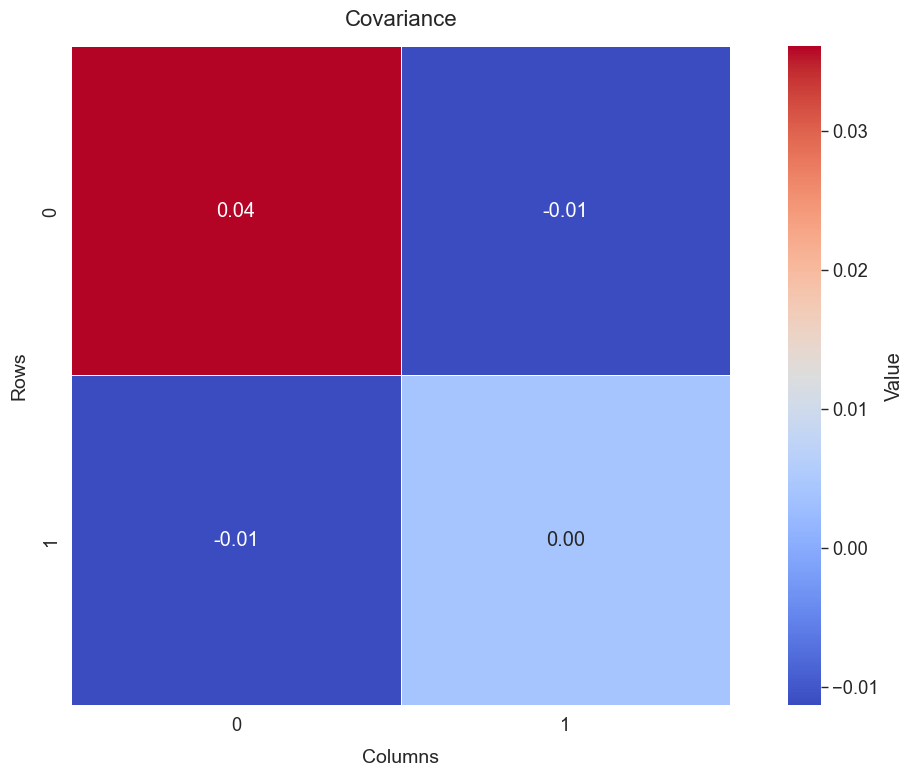

Correlation matrix: [[ 1.         -0.94328401]
 [-0.94328401  1.        ]]


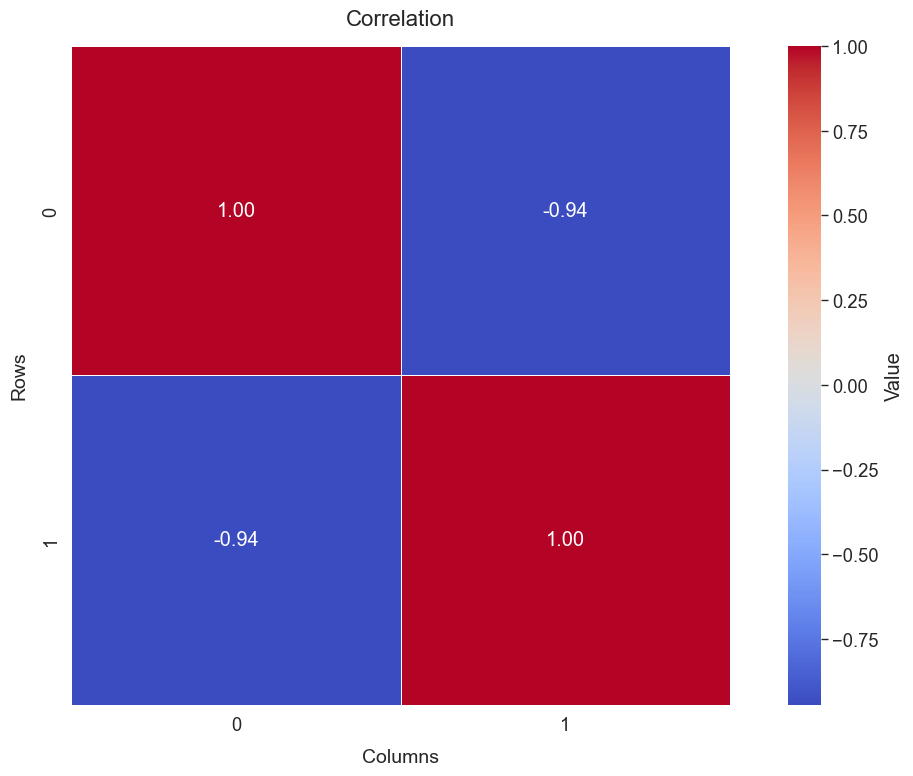

In [18]:
### Compute covariance and correlation matrices of the OLS estimators ###

s2_b = MSE * XXI
print("Variance matrix:", s2_b)

# Set publication-quality style
sns.set_context("paper", font_scale=1.5)  # Adjust font scale for journal format
sns.set_style("whitegrid")  # Clean grid background

# Create the heatmap
plt.figure(figsize=(12, 8))  # Adjust figure size
sns.heatmap(
    s2_b, 
    annot=True,           # Show values in cells
    fmt=".2f",            # Format numbers to 2 decimal places
    cmap="coolwarm",      # Color scheme
    cbar_kws={"label": "Value"},  # Add label to the colorbar
    linewidths=0.5,       # Add spacing between cells
    square=True           # Make cells square
)

# Add axis labels and title
plt.xlabel("Columns", fontsize=14, labelpad=10)
plt.ylabel("Rows", fontsize=14, labelpad=10)
plt.title("Covariance", fontsize=16, pad=15)

# Finalize layout and save
plt.tight_layout()
plt.savefig("cov_heatmap.png", dpi=300)  # Save as PNG with high resolution
plt.show()




# Correlation matrix of the OLS estimators
DInv = np.linalg.inv(np.diag(np.sqrt(np.diag(s2_b))))
correlation_matrix = DInv @ s2_b @ DInv
print("Correlation matrix:", correlation_matrix)

# Set publication-quality style
sns.set_context("paper", font_scale=1.5)  # Adjust font scale for journal format
sns.set_style("whitegrid")  # Clean grid background

# Create the heatmap
plt.figure(figsize=(12, 8))  # Adjust figure size
sns.heatmap(
    correlation_matrix, 
    annot=True,           # Show values in cells
    fmt=".2f",            # Format numbers to 2 decimal places
    cmap="coolwarm",      # Color scheme
    cbar_kws={"label": "Value"},  # Add label to the colorbar
    linewidths=0.5,       # Add spacing between cells
    square=True           # Make cells square
)

# Add axis labels and title
plt.xlabel("Columns", fontsize=14, labelpad=10)
plt.ylabel("Rows", fontsize=14, labelpad=10)
plt.title("Correlation", fontsize=16, pad=15)

# Finalize layout and save
plt.tight_layout()
plt.savefig("cor_heatmap.png", dpi=300)  # Save as PNG with high resolution
plt.show()

In [19]:
# Hypothesis testing for predictions and confidence intervals

# Standard errors
bse = np.sqrt(MSE * np.diag(XXI))
# print(bse)

# t-statistics
t_stats = b_model_1.reshape(len(b_model_1)) / bse
# print(t_stats)

# Using via lm package
beta_hat_lm = model_1.params
std_err_lm = model_1.bse

# t-statistics via lm package
t_stats_lm = beta_hat_lm / std_err_lm
# print(t_stats_lm)

# p-values
p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=n - p - 1))
p_values_lm = 2 * (1 - stats.t.cdf(np.abs(t_stats_lm), df=n - p - 1))

# Print t-stats and p-values
print("\nt-statistics (manually):", t_stats)
print("\nt-statistics (via lm package):", t_stats_lm)

# Iterate through both arrays and print the values
print('\n Manual p-values ', '   lm p-values    ')
print(' --------------- ', '  --------------  ')
for i in range(len(b_model_1)):
    print(f"{p_values[i]:16.2e}  {p_values_lm[i]:16.2e}")

# Confidence Intervals
alpha = 0.05
t_critical = stats.t.ppf(1 - alpha / 2, df=n - p - 1)  # Two-tailed critical t-value
confidence_intervals = np.column_stack((
    b_model_1.reshape(len(b_model_1)) - t_critical * bse,
    b_model_1.reshape(len(b_model_1)) + t_critical * bse
))

print("\n95% Confidence Intervals:")
print('   2.5%   ', '   97.5%   ')
print(' -------- ', ' -------- ')
for i in range(len(confidence_intervals)):
    print(f"{confidence_intervals[i,0]:9.4f}  {confidence_intervals[i,1]:9.4f}")

# Bonferroni-corrected confidence intervals
alpha_bonf = alpha / p
t_critical_bonf = stats.t.ppf(1 - alpha_bonf / 2, df=n - p - 1)
bonferroni_intervals = np.column_stack((
    b_model_1.reshape(len(b_model_1)) - t_critical_bonf * bse,
    b_model_1.reshape(len(b_model_1)) + t_critical_bonf * bse
))

print("\nBonferroni-Corrected Confidence Intervals:")
print('   2.5%   ', '   97.5%   ')
print(' -------- ', ' -------- ')
for i in range(len(bonferroni_intervals)):
    print(f"{bonferroni_intervals[i,0]:9.4f}  {bonferroni_intervals[i,1]:9.4f}")


t-statistics (manually): [ -5.94394658 177.36844767]

t-statistics (via lm package): [ -5.94394658 177.36844767]

 Manual p-values     lm p-values    
 ---------------    --------------  
        5.48e-08          5.48e-08
        0.00e+00          0.00e+00

95% Confidence Intervals:
   2.5%       97.5%   
 --------   -------- 
  -1.5066    -0.7516
  11.0601    11.3107

Bonferroni-Corrected Confidence Intervals:
   2.5%       97.5%   
 --------   -------- 
  -1.5066    -0.7516
  11.0601    11.3107


## Part 1-2. Prediction using MODEL-1

In [20]:
### Forming data required for prediction from prediction dataset ###
df_X_data_pred = pd.DataFrame(data_prediction[118, 83, :, :9], columns=column_names_data_X)
df_Y_pred = pd.DataFrame(data_prediction[118, 83, :, 9], columns=column_names_data_Y)

avg_8temp_preds = np.zeros(num_of_days) # Average temperature of eight surrounding locations
for i in range(num_of_days):
    avg_8temp_preds[i] = (data_prediction[117, 82, i, 9] + 
                          data_prediction[117, 83, i, 9] + 
                          data_prediction[117, 84, i, 9] + 
                          data_prediction[118, 82, i, 9] + 
                          data_prediction[118, 84, i, 9] + 
                          data_prediction[119, 82, i, 9] + 
                          data_prediction[119, 83, i, 9] + 
                          data_prediction[119, 84, i, 9])/8

# Add the new feature to the dataframe
df_X_data_pred['avg8temp'] = avg_8temp_preds


# Turn the data to numpy array
X_pred = df_X_data_pred.to_numpy()
Y_pred = df_Y_pred.to_numpy()

# Display the DataFrame
print('\ndf_X_data_pred: ')
print(df_X_data_pred)
print('\ndf_Y_pred: ')
print(df_Y_pred)


# Create a dataframe for visualizations
merged_df_pred = pd.concat([df_Y_pred, df_X_data_pred], axis=1) # Merge the dataframes (Y and covariates) into one dataframe
merged_df_pred['Days'] = range(1,len(merged_df_pred)+1) # Add a 'Days' column to the dataframe
columns = ['Days'] + [col for col in merged_df_pred.columns if col != 'Days']  # Adjust column order ('Days' before 'Y')
merged_df_pred = merged_df_pred[columns] # Adjust column order ('Days' before 'Y')
print('\nmerged_df_pred: ')
print(merged_df_pred)


df_X_data_pred: 
      ALBEDO    CLDHGH    CLDMID    CLDLOW  QLML       SWGDN      SPEED  \
0   0.185464  0.375039  0.232163  0.045884   NaN   98.463135   4.152839   
1   0.179077  0.643596  0.157792  0.002426   NaN   94.758464   5.485871   
2   0.198906  0.013748  0.042429  0.064518   NaN  102.689779   4.439606   
3   0.152832  0.901616  0.507463  0.173919   NaN   42.453979  12.148642   
4   0.187463  0.461856  0.247018  0.241752   NaN   79.754435  15.793145   
..       ...       ...       ...       ...   ...         ...        ...   
85  0.185221  0.846387  0.608457  0.150602   NaN   92.154566   7.220146   
86  0.193072  0.260720  0.094148  0.231585   NaN  192.558777  14.092669   
87  0.189698  0.000000  0.024749  0.000000   NaN  193.798258   7.604988   
88  0.187423  0.150427  0.000000  0.004685   NaN  187.845540   9.968739   
89  0.166787  0.197164  0.299575  0.348858   NaN  107.079051   8.434246   

         PRECSNO       PRECTOT   avg8temp  
0   0.000000e+00  5.773460e-08  41.73

In [21]:
# Scaling the covariates

# Scaling each covariate by its std
X_RescaledPart2_pred = X_pred * 0 # Initialize an array of zeros with the same shape as X_pred (90,10)
# print(X_RescaledPart2_pred.shape)
for i in range(len(X_pred[0,:])):
    X_RescaledPart2_pred[:,i] = X_pred[:,i]/np.std(X_pred[:,i])
    

(90,)
(90,)
<class 'numpy.ndarray'>


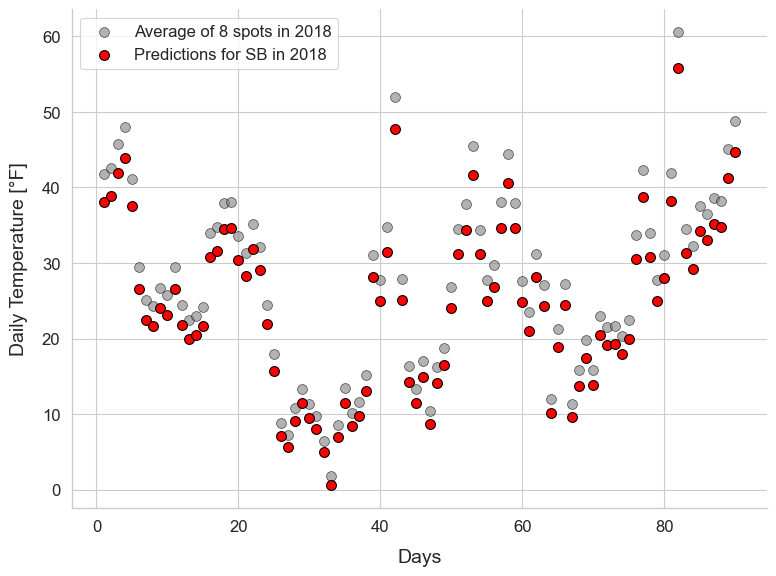

In [22]:
### Prediction dataset (The Y is not known, so we cannot compute MSE and residuals from comparing Y_hat & Y) ###

# Defining the model input for prediction dataset
X_MODEL_1_pred = X_RescaledPart2_pred[:,9] # Only avg8temp
print(X_MODEL_1_pred.shape)

# Compute the predictions
Y_hat_pred = b_model_1[0][0] + b_model_1[1][0] * X_MODEL_1_pred
print(Y_hat_pred.shape)
print(type(Y_hat_pred))

# Plotting to see the average temperature of surrounding areas and the predicted temperature for SB over days
sns.set_context("paper", font_scale=1.5)  # Adjust for a smaller, journal-like scale
sns.set_style("whitegrid")  # Clean background with grid lines
plt.figure(figsize=(8, 6))  # Set figure size to typical journal dimensions
sns.scatterplot(x="Days", y="avg8temp", data=merged_df_pred, s=50, color="gray", label='Average of 8 spots in 2018', marker="o", edgecolor='black', alpha=0.6)
# plt.scatter(merged_df['Days'], Y_hat, color='gray', label='avg8temp', s=50, edgecolor='black')
plt.scatter(merged_df_pred['Days'], Y_hat_pred, color='red', label='Predictions for SB in 2018', s=50, edgecolor='black')
plt.xlabel("Days", fontsize=14, labelpad=10) # Set X-axis labels
plt.ylabel("Daily Temperature [°F]", fontsize=14, labelpad=10) # Set Y-axis labels
plt.xticks(fontsize=12) # Add ticks and their sizes
plt.yticks(fontsize=12) # Add ticks and their sizes
sns.despine() # Remove top and right spines for a cleaner look
plt.legend(loc="upper left", fontsize=12) # Add a legend
plt.tight_layout() # Set tight layout for better space usage
plt.savefig('Pred4predDatasetVSavg8temp.png', dpi=300) # Save the plot as png
plt.show()


In [23]:
# Saving predictions to share with TA
np.savetxt('Farzad_Reza.csv', Y_hat_pred)

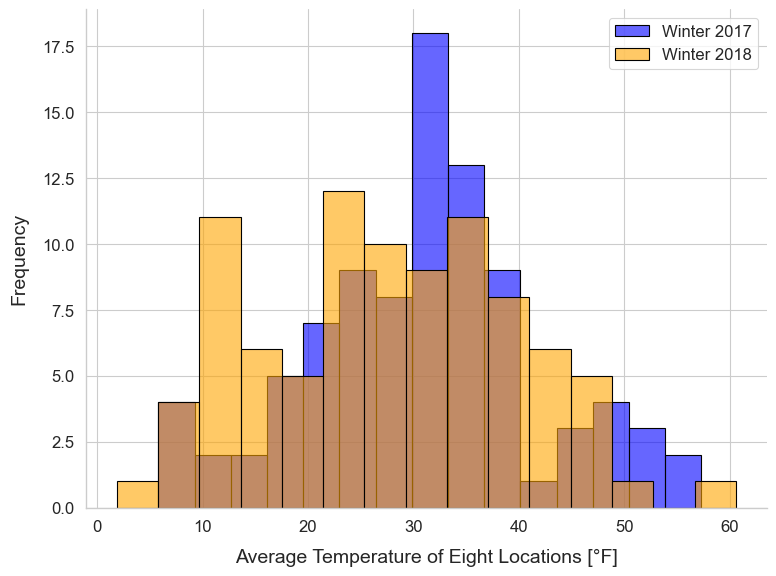

In [24]:
# Plotting the histogram of eight surrounding spots in winter 2017 (training dataset) and winter 2018 (prediction dataset)

avg8temp_2017 = merged_df['avg8temp'].values
avg8temp_2018 = merged_df_pred['avg8temp'].values

# Set Seaborn context and style
sns.set_context("paper", font_scale=1.5)
sns.set_style("whitegrid")

# Create the figure
plt.figure(figsize=(8, 6))

# Plot histograms
sns.histplot(avg8temp_2017, bins=15, kde=False, color="blue", label="Winter 2017", alpha=0.6, edgecolor='black')
sns.histplot(avg8temp_2018, bins=15, kde=False, color="orange", label="Winter 2018", alpha=0.6, edgecolor='black')

# Customize labels and appearance
plt.xlabel("Average Temperature of Eight Locations [°F]", fontsize=14, labelpad=10)  # Adjust X-axis label
plt.ylabel("Frequency", fontsize=14, labelpad=10)  # Adjust Y-axis label
plt.xticks(fontsize=12)  # Set X-tick font size
plt.yticks(fontsize=12)  # Set Y-tick font size
plt.legend(loc="upper right", fontsize=12)  # Add legend
sns.despine()  # Clean up the axes
plt.tight_layout()  # Adjust layout to prevent overlap

# Save the figure
plt.savefig('avg8temp2017vs2018_hist.png', dpi=300)

# Show the plot
plt.show()

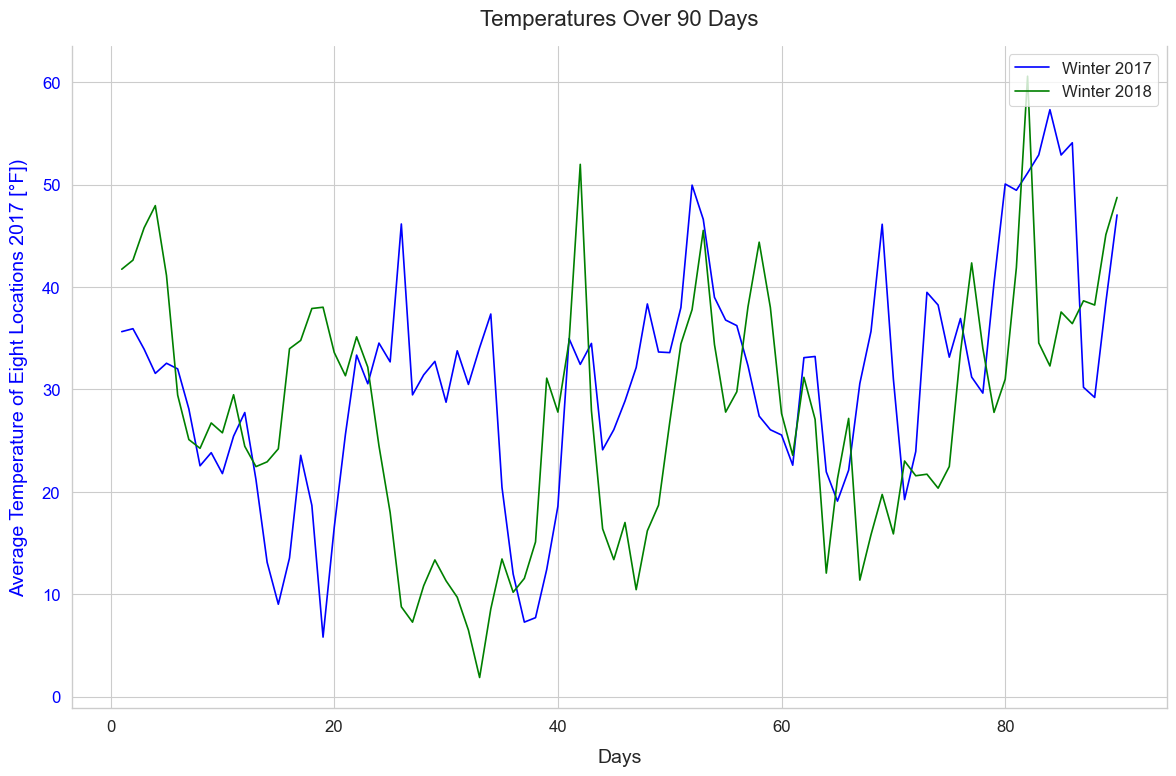

In [25]:
# Plotting the South Bend and the average of its surroundings temperature trends over 90 days

# Set style and context
sns.set_context("paper", font_scale=1.5)  # Adjust for a smaller, journal-like scale
sns.set_style("whitegrid")  # Clean background with grid lines

# Create figure and primary axis for temperature
fig, ax1 = plt.subplots(figsize=(12, 8))  # Set figure size to typical journal dimensions

# Plot Daily Temperature as a line plot on the primary axis
sns.lineplot(x="Days", y="avg8temp", data=merged_df, color="blue", label="Winter 2017")
sns.lineplot(x="Days", y="avg8temp", data=merged_df_pred, color="green", label="Winter 2018")
ax1.set_xlabel("Days", fontsize=14, labelpad=10)
ax1.set_ylabel("Average Temperature of Eight Locations 2017 [°F])", fontsize=14, labelpad=10, color="blue")
ax1.tick_params(axis="y", labelcolor="blue", labelsize=12)
ax1.tick_params(axis="x", labelsize=12)

# Create a secondary axis for South-to-North wind speed
# ax2 = ax1.twinx()
# sns.lineplot(x="Days", y="avg8temp", data=merged_df_pred, color="green", ax=ax2)
# ax2.set_ylabel("Average Temperature of Eight Locations 2018 [°F])", fontsize=14, labelpad=10, color="green")
# ax2.tick_params(axis="y", labelcolor="green", labelsize=12)

# Add title
plt.title("Temperatures Over 90 Days", fontsize=16, pad=15)

# Clean up and finalize
sns.despine(ax=ax1, right=False)  # Remove unnecessary spines
fig.tight_layout()  # Ensure proper layout for publication
plt.legend(loc="upper right", fontsize=12)  # Add legend
plt.savefig("avg8temp2017vs2018_trend.png", dpi=300)  # Save as PNG with high DPI
plt.show()

# Part 2. Simulation Study

In [26]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.api import OLS, add_constant
from statsmodels.tools.eval_measures import aic, bic

In [27]:

########################
### Define functions ###
########################

# Function to simulate data
def generate_data(n=100, p=10, relevant_p=5, noise_std=1.0, seed=2024):
    np.random.seed(seed)
    X = np.random.normal(0, 1, (n, p))
    beta = np.concatenate([np.random.uniform(1, 3, relevant_p), np.zeros(p - relevant_p)])
    # print(beta.shape,beta)
    epsilon = np.random.normal(0, noise_std, n)
    y = X @ beta + epsilon
    # print(y.shape, y)
    return X, y, beta

# Function to calculate selection criteria
def evaluate_criteria(X_train, X_test, y_train, y_test, selected_features):
    X_train_subset = X_train[:, selected_features]
    X_test_subset = X_test[:, selected_features]
    model = LinearRegression().fit(X_train_subset, y_train)
    
    # Calculate predictions and metrics
    y_pred = model.predict(X_test_subset)
    mse = mean_squared_error(y_test, y_pred)
    r2 = model.score(X_test_subset, y_test)
    adj_r2 = 1 - (1 - r2) * (len(y_train) - 1) / (len(y_train) - len(selected_features) - 1)
    
    # AIC and BIC
    X_train_const = add_constant(X_train_subset)
    sm_model = OLS(y_train, X_train_const).fit()
    aic_value = sm_model.aic
    bic_value = sm_model.bic

    return {"MSE": mse, "R2": r2, "Adjusted R2": adj_r2, "AIC": aic_value, "BIC": bic_value} # Returns a dictionary of criteria

##########################
### Main Code (Case 1) ###
##########################

# Simulate the data
n, p, relevant_p = 500, 15, 10 # Enter inputs
print('\n     n: ',n , ' , p: ', p, ' , relevant_p: ', relevant_p)
print('   ----------------------------------------')
X, y, true_beta = generate_data(n=n, p=p, relevant_p=relevant_p) # GEnerate data
# print(X.shape, y.shape, true_beta.shape)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Evaluate different models
results = []
for k in range(1, p + 1):  # Test models with 1 to p predictors
    selected_features = list(range(k))
    criteria = evaluate_criteria(X_train, X_test, y_train, y_test, selected_features)
    criteria["Num_Features"] = k # Adding the element "Num_Features" to the dictionary of criteria
    results.append(criteria)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
desired_col_order = ["Num_Features", "MSE", "R2", "Adjusted R2", "AIC", "BIC"]
results_df = results_df[desired_col_order]
print(results_df.round(2))



     n:  500  , p:  15  , relevant_p:  10
   ----------------------------------------
    Num_Features    MSE    R2  Adjusted R2      AIC      BIC
0              1  36.33  0.07         0.07  2326.28  2333.99
1              2  33.77  0.13         0.13  2314.74  2326.32
2              3  31.58  0.19         0.18  2248.98  2264.41
3              4  27.62  0.29         0.28  2198.80  2218.09
4              5  26.19  0.33         0.32  2189.47  2212.62
5              6  27.95  0.28         0.27  2174.65  2201.66
6              7  18.66  0.52         0.51  1989.59  2020.46
7              8  10.04  0.74         0.74  1810.24  1844.97
8              9   4.14  0.89         0.89  1545.31  1583.89
9             10   0.99  0.97         0.97  1027.07  1069.51
10            11   0.99  0.97         0.97  1026.62  1072.91
11            12   0.99  0.97         0.97  1028.54  1078.69
12            13   0.99  0.97         0.97  1030.53  1084.54
13            14   0.99  0.97         0.97  1032.24  1090.1

In [28]:

##########################
### Main Code (Case 2) ###
##########################

# Simulate the data
n, p, relevant_p = 20, 10, 5 # Enter inputs
print('\n     n: ',n , ' , p: ', p, ' , relevant_p: ', relevant_p)
print('   ----------------------------------------')
X, y, true_beta = generate_data(n=n, p=p, relevant_p=relevant_p) # GEnerate data
# print(X.shape, y.shape, true_beta.shape)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Evaluate different models
results = []
for k in range(1, p + 1):  # Test models with 1 to p predictors
    selected_features = list(range(k))
    criteria = evaluate_criteria(X_train, X_test, y_train, y_test, selected_features)
    criteria["Num_Features"] = k # Adding the element "Num_Features" to the dictionary of criteria
    results.append(criteria)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
desired_col_order = ["Num_Features", "MSE", "R2", "Adjusted R2", "AIC", "BIC"]
results_df = results_df[desired_col_order]
print(results_df.round(2))


     n:  20  , p:  10  , relevant_p:  5
   ----------------------------------------
   Num_Features    MSE    R2  Adjusted R2    AIC    BIC
0             1  35.11 -1.61        -1.83  92.82  94.10
1             2  28.02 -1.08        -1.46  84.57  86.48
2             3   4.12  0.69         0.60  76.96  79.52
3             4   3.90  0.71         0.58  70.81  74.01
4             5   1.72  0.87         0.79  40.35  44.19
5             6   1.74  0.87         0.76  42.13  46.60
6             7   1.54  0.89         0.75  44.06  49.17
7             8   2.00  0.85         0.61  44.28  50.04
8             9   6.84  0.49        -0.65  43.15  49.54
9            10   6.11  0.55        -0.97  45.11  52.14


In [29]:

##########################
### Main Code (Case 3) ###
##########################

# Simulate the data
n, p, relevant_p = 50, 20, 15 # Enter inputs
print('\n     n: ',n , ' , p: ', p, ' , relevant_p: ', relevant_p)
print('   ----------------------------------------')
X, y, true_beta = generate_data(n=n, p=p, relevant_p=relevant_p) # GEnerate data
# print(X.shape, y.shape, true_beta.shape)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Evaluate different models
results = []
for k in range(1, p + 1):  # Test models with 1 to p predictors
    selected_features = list(range(k))
    criteria = evaluate_criteria(X_train, X_test, y_train, y_test, selected_features)
    criteria["Num_Features"] = k # Adding the element "Num_Features" to the dictionary of criteria
    results.append(criteria)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
desired_col_order = ["Num_Features", "MSE", "R2", "Adjusted R2", "AIC", "BIC"]
results_df = results_df[desired_col_order]
print(results_df.round(2))


     n:  50  , p:  20  , relevant_p:  15
   ----------------------------------------
    Num_Features    MSE    R2  Adjusted R2     AIC     BIC
0              1  61.29 -0.05        -0.08  252.40  255.51
1              2  56.53  0.03        -0.03  253.42  258.08
2              3  47.91  0.18         0.10  247.03  253.25
3              4  34.97  0.40         0.32  236.72  244.50
4              5  33.01  0.44         0.34  237.96  247.29
5              6  33.02  0.44         0.31  239.96  250.85
6              7  33.17  0.43         0.29  241.49  253.93
7              8  21.10  0.64         0.53  236.10  250.10
8              9  26.23  0.55         0.39  231.51  247.06
9             10  26.82  0.54         0.35  229.04  246.14
10            11  25.66  0.56         0.35  229.94  248.61
11            12  16.48  0.72         0.56  218.68  238.90
12            13   9.90  0.83         0.73  200.88  222.66
13            14   9.37  0.84         0.73  159.99  183.32
14            15   2.42  0.96

In [33]:

##########################
### Main Code (Case 4) ###
##########################

# Simulate the data
n, p, relevant_p = 5000, 20, 10 # Enter inputs
print('\n     n: ',n , ' , p: ', p, ' , relevant_p: ', relevant_p)
print('   ----------------------------------------')
X, y, true_beta = generate_data(n=n, p=p, relevant_p=relevant_p) # GEnerate data
# print(X.shape, y.shape, true_beta.shape)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Evaluate different models
results = []
for k in range(1, p + 1):  # Test models with 1 to p predictors
    selected_features = list(range(k))
    criteria = evaluate_criteria(X_train, X_test, y_train, y_test, selected_features)
    criteria["Num_Features"] = k # Adding the element "Num_Features" to the dictionary of criteria
    results.append(criteria)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
desired_col_order = ["Num_Features", "MSE", "R2", "Adjusted R2", "AIC", "BIC"]
results_df = results_df[desired_col_order]
print(results_df.round(2))


     n:  5000  , p:  20  , relevant_p:  10
   ----------------------------------------
    Num_Features    MSE    R2  Adjusted R2       AIC       BIC
0              1  54.35  0.05         0.05  23966.80  23979.12
1              2  45.70  0.20         0.20  23364.67  23383.15
2              3  39.01  0.32         0.32  22838.02  22862.66
3              4  37.25  0.35         0.35  22725.74  22756.55
4              5  29.63  0.48         0.48  21861.43  21898.39
5              6  21.06  0.63         0.63  20817.12  20860.25
6              7  19.91  0.65         0.65  20587.79  20637.08
7              8  11.12  0.81         0.81  18501.85  18557.29
8              9   5.70  0.90         0.90  16245.34  16306.94
9             10   1.03  0.98         0.98   9947.19  10014.95
10            11   1.03  0.98         0.98   9947.48  10021.40
11            12   1.03  0.98         0.98   9948.78  10028.87
12            13   1.03  0.98         0.98   9950.38  10036.63
13            14   1.03  0.98 